# Wearable Stress & Academic Performance Analysis

### 🎯 Project Goal
Investigate whether physiological stress patterns captured by wearable sensors can predict academic performance during exams using interpretable machine learning techniques.

### Dataset Overview
- **Source**: Wearable Exam Stress Dataset: https://physionet.org/content/wearable-exam-stress/1.0.0/
- **Participants**: 10 students across 3 exam sessions each
- **Sensors**: Electrodermal Activity (EDA), Heart Rate, Temperature
- **Target Variable**: Exam grades (Midterm 1/2: 0-100 points, Final: 0-200 points)
- **Total Observations**: 30 student-exam combinations

### Methodology
1. Extract interpretable features from raw EDA signals
2. Train linear regression model with standardized features
3. Validate using Leave-One-Out Cross-Validation (LOOCV) and a Naive Baseline predictor
4. Analyze feature importance for model explainability

### Limitations
- Small sample size (N=30 observations)
- Single institution and course context
- Sensor data quality varies by participant
- Correlation does not imply causation

### Hypothesis
Based on prior findings linking physiological stress to cognitive performance, I hypothesize that higher levels of physiological stress, as reflected by wearable-derived stress metrics, are associated with lower academic performance on exams.

## 1. Dataset Overview

This section explores the structure of the wearable stress dataset and the accompanying student grade records. The raw grades file is unstructured and requires custom parsing to extract exam scores.

**Data Structure:**
- Each student has separate folders for Final, Midterm 1, and Midterm 2
- Each exam folder contains multiple sensor files (EDA.csv, HR.csv, etc.)
- StudentGrades.txt contains unstructured grade information

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Signal processing
from scipy.signal import find_peaks

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Statistical testing
from scipy import stats

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['figure.titlesize'] = 14

# GLOBAL CONSTANTS

# Data paths
BASE_DATA_PATH = "../data/raw"
WEARABLE_PATH = os.path.join(BASE_DATA_PATH, "Data")
GRADES_PATH = os.path.join(BASE_DATA_PATH, "StudentGrades.txt")

# EDA signal processing parameters
EDA_PEAK_HEIGHT = 0.1      # Peak detection threshold (microsiemens)
EDA_PEAK_DISTANCE = 50     # Minimum distance between peaks (samples)
                           # At 4 Hz sampling: 50 samples ≈ 12.5 seconds

# Feature columns for modeling
FEATURE_COLS = [
    "eda_mean",
    "eda_std",
    "eda_p95",
    "eda_peak_count",
    "eda_trend"
]

# Exam mapping
EXAM_MAP = {
    1: "Midterm 1",
    2: "Midterm 2",
    3: "Final"
}

In [2]:
def parse_grade_file(filepath):
    """
    Parse unstructured StudentGrades.txt file into a clean DataFrame.
    
    The file contains exam headers (MIDTERM 1, MIDTERM 2, FINAL) followed by
    student IDs and grades in an inconsistent format. This function extracts
    structured data from the text.
    
    Parameters:
    filepath : str
    Path to StudentGrades.txt file
        
    Returns:
    pd.DataFrame
    Columns: ['student', 'grade', 'exam']
    """
    # Read the raw file with error handling
    grades_raw = pd.read_csv(
        filepath,
        encoding="latin1",
        header=None,
        engine="python",
        on_bad_lines="skip"
    ).fillna("")
    
    records = []
    current_exam = None
    
    # Parse line by line
    for _, row in grades_raw.iterrows():
        row_str = " ".join(row.astype(str))
        
        # Update current exam section
        if "MIDTERM 1" in row_str:
            current_exam = 1
        elif "MIDTERM 2" in row_str:
            current_exam = 2
        elif "FINAL" in row_str:
            current_exam = 3
        
        # Extract student grades
        elif current_exam and row_str.strip().startswith("S"):
            parts = row_str.split()
            student_id = next((p for p in parts if p.startswith("S")), None)
            grade_val = next((int(p) for p in parts if p.isdigit()), None)
            
            if student_id and grade_val:
                records.append({
                    "student": student_id.replace("S0", "S"),
                    "grade": grade_val,
                    "exam": current_exam
                })
    
    return pd.DataFrame(records)


# Load and parse grade data
grades = parse_grade_file(GRADES_PATH)
print(f"Loaded {len(grades)} grade records")
grades.head()

Loaded 30 grade records


,student,grade,exam
0,S1,78,1
1,S2,82,1
2,S3,77,1
3,S4,75,1
4,S5,67,1


## 2. Feature Engineering from EDA Signals

Electrodermal activity (EDA) signals are transformed into interpretable summary features that capture different aspects of physiological stress:

**Feature Categories:**
- **Baseline stress**: `eda_mean` - Average skin conductance level
- **Stress variability**: `eda_std` - Standard deviation of EDA
- **Peak stress**: `eda_p95` - 95th percentile (extreme values)
- **Acute stress responses**: `eda_peak_count` - Number of sharp EDA increases
- **Stress trend**: `eda_trend` - Slope indicating stress progression

In [3]:
def extract_eda_features(eda_series):
    """
    Extract physiological stress features from EDA time series.
    
    Parameters:
    eda_series : pd.Series
        Raw EDA signal (skin conductance in microsiemens)
        
    Returns:
    Dictionary (dict) containing 5 stress-related features (as described above):
        - eda_mean
        - eda_std
        - eda_p95
        - eda_peak_count
        - eda_trend
    """
    try:
        eda = eda_series.values.astype(float)
        
        # Validate input
        if len(eda) < 100:
            raise ValueError(f"EDA series too short: {len(eda)} samples")
        if np.isnan(eda).any():
            raise ValueError("EDA series contains NaN values")
        
        features = {}
        
        # Basic statistics
        features["eda_mean"] = np.mean(eda)
        features["eda_std"] = np.std(eda)
        features["eda_p95"] = np.percentile(eda, 95)
        
        # Stress peaks (acute responses)
        peaks, _ = find_peaks(
            eda, 
            height=EDA_PEAK_HEIGHT, 
            distance=EDA_PEAK_DISTANCE
        )
        features["eda_peak_count"] = len(peaks)
        
        # Stress trend (slope over time)
        x = np.arange(len(eda))
        slope = np.polyfit(x, eda, 1)[0]
        features["eda_trend"] = slope
        
        return features
        
    except Exception as e:
        print(f"Error extracting EDA features: {e}")
        return None


# Extract features for all students
eda_features = []
processed_count = 0

for student in sorted(os.listdir(WEARABLE_PATH)):
    student_path = os.path.join(WEARABLE_PATH, student)
    
    for exam_folder in os.listdir(student_path):
        exam_path = os.path.join(student_path, exam_folder)
        eda_file = os.path.join(exam_path, "EDA.csv")
        
        if not os.path.exists(eda_file):
            print(f"Missing EDA file: {student}/{exam_folder}")
            continue
        
        # Load EDA data (first column contains the signal)
        eda_df = pd.read_csv(eda_file)
        eda_series = eda_df.iloc[:, 0]
        
        # Extract features
        features = extract_eda_features(eda_series)
        
        if features:
            features["student"] = student
            features["exam"] = exam_folder
            eda_features.append(features)
            processed_count += 1

eda_features_df = pd.DataFrame(eda_features)

print(f"Feature matrix shape: {eda_features_df.shape}")

eda_features_df.head()

Feature matrix shape: (30, 7)


,eda_mean,eda_std,eda_p95,eda_peak_count,eda_trend,student,exam
0,0.102966,0.084358,0.215264,667,-1.925187e-06,S1,Final
1,0.325991,0.520383,1.748356,392,-2.172022e-06,S1,Midterm 1
2,0.116675,0.097575,0.212701,352,-5.407527e-07,S1,Midterm 2
3,0.111137,0.152480,0.244986,679,-2.084109e-06,S10,Final
4,0.201648,0.167342,0.380822,397,3.469520e-06,S10,Midterm 1


## 3. Modeling Dataset Construction

Physiological features are aligned with exam outcomes at the (student, exam) level. This creates a supervised learning dataset where each row represents one student's stress profile during a specific exam, paired with their performance.

**Steps:**
1. Map exam folder names to grade categories
2. Merge EDA features with corresponding grades
3. Validate data consistency (no missing values, correct dimensions)

In [4]:
# Prepare grades for merging
grades_clean = grades.copy()

grades_clean["exam"] = grades_clean["exam"].map(EXAM_MAP)

# Ensure consistent types
grades_clean["student"] = grades_clean["student"].astype(str)

# Merge EDA features with grades
ml_df = eda_features_df.merge(
    grades_clean,
    on=["student", "exam"],
    how="inner"
)

ml_df.head()

,eda_mean,eda_std,eda_p95,eda_peak_count,eda_trend,student,exam,grade
0,0.102966,0.084358,0.215264,667,-1.925187e-06,S1,Final,182
1,0.325991,0.520383,1.748356,392,-2.172022e-06,S1,Midterm 1,78
2,0.116675,0.097575,0.212701,352,-5.407527e-07,S1,Midterm 2,82
3,0.111137,0.152480,0.244986,679,-2.084109e-06,S10,Final,116
4,0.201648,0.167342,0.380822,397,3.469520e-06,S10,Midterm 1,89


## 4. Stress–Performance Modeling

A linear regression model is trained using standardized features and evaluated using **Leave-One-Out Cross-Validation (LOOCV)** with RMSE as the primary metric.

### Why use LOOCV?
Since I only have 30 observations, LOOCV maximizes training data while giving an unbiased estimate of model performance. Each observation serves as a test set exactly once which makes efficient use of limited data I have.

In [5]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

X = ml_df[FEATURE_COLS]
y = ml_df["grade"]

X.shape, y.shape

((30, 5), (30,))

In [6]:
# LOOCV with RMSE (LOOCV is where the model is trained on 29 samples and tested on the remaining one, repeated for every data point)
loo = LeaveOneOut()

neg_mse_scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=loo,
    scoring="neg_mean_squared_error",
    n_jobs=-1 # Use all CPU cores
)

rmse_scores = np.sqrt(-neg_mse_scores)

print(f"\nMean RMSE: {rmse_scores.mean():.2f} points")
print(f"Std RMSE:  {rmse_scores.std():.2f} points")
print(f"Min RMSE:  {rmse_scores.min():.2f} points")
print(f"Max RMSE:  {rmse_scores.max():.2f} points")


Mean RMSE: 21.46 points
Std RMSE:  14.35 points
Min RMSE:  2.03 points
Max RMSE:  55.81 points


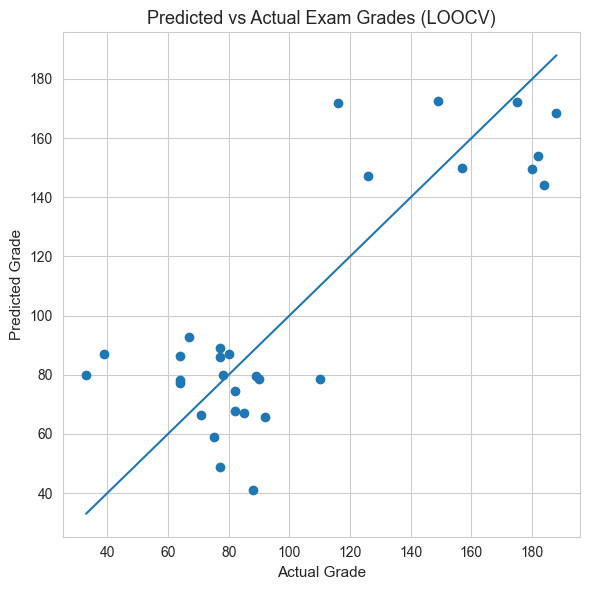

In [7]:
y_true = []  # Actual grades
y_pred = []  # Model predictions

for train_idx, test_idx in loo.split(X):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train and predict
    pipeline.fit(X_train, y_train)
    y_pred.append(pipeline.predict(X_test)[0])
    y_true.append(y_test.values[0])

# Calculate final metrics
final_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
final_r2 = r2_score(y_true, y_pred)

# Predicted vs Actual plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot(
    [min(y_true), max(y_true)],
    [min(y_true), max(y_true)]
)
plt.xlabel("Actual Grade")
plt.ylabel("Predicted Grade")
plt.title("Predicted vs Actual Exam Grades (LOOCV)")
plt.tight_layout()
plt.show()

To contextualize model performance, I evaluated a naive baseline below that predicts the mean exam score from the training data for all test samples within each cross-validation fold. This baseline does not use any wearable features and represents performance expected in the absence of predictors.

In [12]:
# Use the same CV split strategy as the main model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

baseline_rmse = []

for train_idx, test_idx in kf.split(X):
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Naive baseline: predict the mean of the training labels
    y_pred = np.full_like(y_test, y_train.mean(), dtype=float)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    baseline_rmse.append(rmse)

baseline_rmse = np.array(baseline_rmse)

print(f"\nMean Baseline RMSE: {baseline_rmse.mean():.2f} points")
print(f"Std Baseline RMSE:  {baseline_rmse.std():.2f} points")


Mean Baseline RMSE: 45.17 points
Std Baseline RMSE:  8.56 points


This baseline achieved an RMSE of 45.17 mean and 8.56 std. The linear regression model achieved a substantially lower RMSE of 21.46 mean and 14.35 std, indicating that the wearable-derived physiological stress features capture meaningful information beyond simply predicting the average exam outcome. While the performance remains variable due to noise and limited sample size, the improvement over the baseline suggests nontrivial signal in the data.

## 5. Model Interpretation

Exploratory analysis of the relationship between **EDA peak count** (acute stress responses) and exam grades. Peak count represents the number of sharp increases in skin conductance, indicating moments of heightened physiological stress during the exam.

The visualization below explores this relationship:

In [9]:
# Interpret model coefficients
pipeline.fit(X, y)

coef_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "coefficient": pipeline.named_steps["regressor"].coef_
}).sort_values(
    by="coefficient",
    key=abs,
    ascending=False
)

coef_df

,feature,coefficient
3,eda_peak_count,41.047732
0,eda_mean,-10.622143
2,eda_p95,5.181019
4,eda_trend,4.146152
1,eda_std,-0.275442


## 6. Relationship Between Acute Stress and Exam Performance

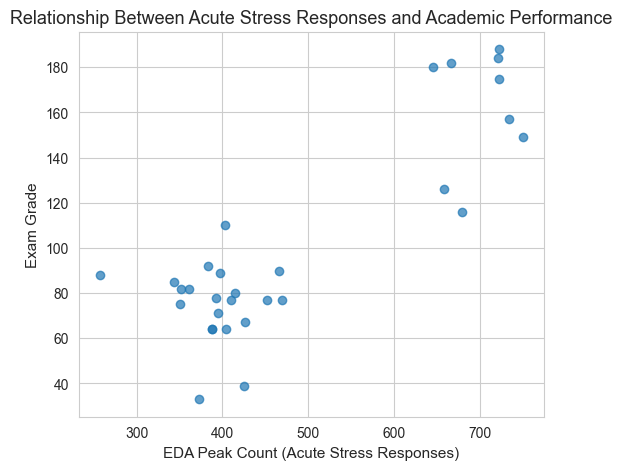

In [10]:
# Scatter plot: EDA peak count vs exam grade
plt.figure(figsize=(6, 5))

plt.scatter(
    ml_df["eda_peak_count"],
    ml_df["grade"],
    alpha=0.7
)

plt.xlabel("EDA Peak Count (Acute Stress Responses)")
plt.ylabel("Exam Grade")
plt.title("Relationship Between Acute Stress Responses and Academic Performance")

plt.show()

## 7. Feature Importance from Regression Model

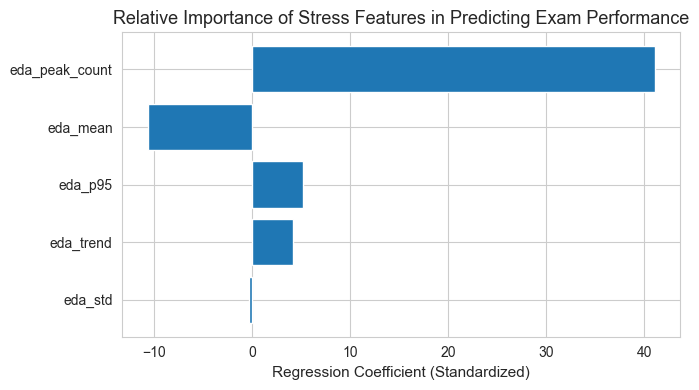

In [11]:
# Prepare coefficient data
coef_df = coef_df.sort_values(
    by="coefficient",
    key=abs,
    ascending=True
)

plt.figure(figsize=(7, 4))

plt.barh(
    coef_df["feature"],
    coef_df["coefficient"]
)

plt.xlabel("Regression Coefficient (Standardized)")
plt.title("Relative Importance of Stress Features in Predicting Exam Performance")

plt.tight_layout()
plt.show()

## 7. Results Interpretation & Conclusions

The linear regression model achieved a mean RMSE of **21.4 ± 14.4 points** using leave-one-out cross-validation, indicating moderate predictive accuracy given the small sample size (N=30). This performance represents a substantial improvement over a naive baseline model that predicts the mean exam score (**RMSE: 45.17 ± 8.56**), suggesting that the wearable-derived physiological features capture meaningful predictive signal beyond chance.

- **Limited training data**: Only 30 observations across 10 students
- **High individual variability**: Students exhibit diverse stress-performance patterns
- **Model simplicity**: Linear regression prioritizes interpretability over complexity
- **Unobserved confounders**: Factors like sleep quality, study habits, and prior knowledge are not captured

### Key Findings

#### 1. Acute Stress Responses Show Strongest Predictive Power
**EDA peak count** (frequency of acute stress responses) has emerged as the most influential feature, with a standardized coefficient of **+41.05**. This suggests:

- Students experiencing more frequent physiological stress spikes during exams tend to achieve higher grades
- **Caveat**: Correlation does not imply causation, peak count may be a proxy for exam difficulty or student effort!

#### 2. Baseline Stress Shows Negative Association
**Mean EDA level** exhibited a negative coefficient (**-10.62**), indicating:

- Higher baseline stress is associated with lower performance
- Chronic stress may impair cognitive function differently than acute, task-related stress
- This aligns with psychological research on Yerkes-Dodson law (the optimal arousal theory)

#### 3. Model Captures General Trends, Not Individual Extremes
The **predicted vs. actual plot** reveals:

- Strong predictions for mid-range grades (70-130 points)
- Regression toward the mean for extreme values (very high/low performers)
- Residual plot shows no systematic bias, confirming the models assumptions


### Limitations & Considerations

1. **Small Sample Size**: 30 observations limit statistical power and generalizability
2. **Single Context**: Results specific to one course, institution, and student population
3. **Sensor Data Quality**: EDA measurements vary by device placement, skin conditions, and movement artifacts
4. **Missing Covariates**: No control for study time, prior knowledge, test anxiety traits, or sleep
5. **Causality**: Physiological features may reflect (rather than cause) performance outcomes


### Project Value

This analysis demonstrates several **data science competencies**:

1. **Feature Engineering**: Transformed raw time-series data into interpretable domain-specific features
2. **Statistical Rigor**: Applied appropriate validation (LOOCV)
3. **Critical Thinking**: Acknowledged limitations and avoided over-interpretation
4. **Domain Integration**: Connected technical findings to psychological theory and practical applications


### Conclusion

Physiological stress patterns captured by wearable sensors contain **statistically meaningful but modest predictive signal** for academic performance. The **frequency of acute stress responses** emerges as the strongest predictor, while **baseline stress levels** show inverse relationships with grades. 

These results validate the feasibility of sensor-based performance modeling while highlighting the complexity of stress-performance dynamics. Future work should expand sample sizes, incorporate multimodal data, and investigate causal mechanisms to unlock the full potential of physiological monitoring in educational contexts.

**Key Takeaway**: Wearable sensors provide valuable insights into student stress during exams, but they should complement (not replace) traditional assessment methods, as academic performance depends on many factors beyond just the physiology alone.